# Human connectome analysis and classification
**Author: Brandon Liu**

<br>

# Data Citation:
Csaba Kerepesi, Balázs Szalkai, Bálint Varga, Vince Grolmusz: The braingraph.org Database of High Resolution Structural Connectomes and the Brain Graph Tools, Cognitive Neurodynamics Vol. 11 No. 5, pp. 483-486 (2017)<br> <a href="http://dx.doi.org/10.1007/s11571-017-9445-1">http://dx.doi.org/10.1007/s11571-017-9445-1</a>

**Description:** 86 nodes set, 1064 brains, 1 000 000 streamlines, 10x repeated & averaged 

In this jupyter notebook, we will perform network analysis on a large dataset of 1064 healthy adult brains' connectivity data derived from MRI scans. We will begin by visualizing a single brain network and exploring its properties. Then, we will look for features in each network and attempt graph classification/regression using known information about the subjects, such as gender, age, and various other fields.

# Import Libraries

In [2]:
import numpy as np
import networkx as nx
from graspologic.plot import heatmap, networkplot
import matplotlib.pyplot as plt
import pandas as pd
import os
from graspologic.partition import leiden, modularity
from graspologic.utils import is_symmetric
from graspologic.utils import largest_connected_component



# Sample Network - Exploratory Analysis

Let's begin by loading a single graph from our dataset, visualizing it and exploring some of it's basic properties


In [2]:
all_mats = os.listdir("braingraph_low")
g = nx.read_graphml("braingraph_low/" + all_mats[0])
n = len(g.nodes())
print("Number of nodes: " + str(n))


Number of nodes: 83


# Data Pre-processing and heatmap

Graph is symmetric: True


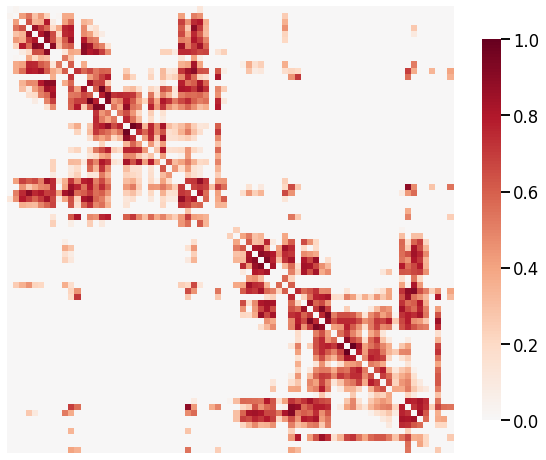

In [23]:
#Use the largest connected component
lcc = max(nx.connected_components(g), key=len)
g = g.subgraph(lcc).copy()

#Extract the weight data
fibers = nx.get_edge_attributes(g, 'number_of_fibers')
weights_only = list(fibers.values())

#Convert weights to a log 10 representation for easier visualization and normalize between 0 and 1
x = np.log10(weights_only)
xmin = min(x)
xmax = max(x)

count = 0
for u, v in fibers.items():
    normalized = (x[count]-xmin)/(xmax-xmin)
    fibers[u] = normalized
    count+=1

nx.set_edge_attributes(g, fibers,"weight")

#Return adjacency matrix
A = nx.to_numpy_array(g)


heatmap(A)
print("Graph is symmetric: "  + str(is_symmetric(A)))

<br>
Our graph appears to be weighted and symmetric. Looking at the heatmap, we can observe two distinct groups in our dataset. Let's plot the network graph to see if we can identify what each group represent.

# Network Plot and description

,x,y,degree,region
1,34.088963,83.558516,6,rh.lateralorbitofrontal
5,21.598875,82.398714,13,rh.parstriangularis
6,20.672714,73.928882,16,rh.parsopercularis
7,28.557744,87.776445,23,rh.rostralmiddlefrontal
8,39.803047,79.357587,22,rh.superiorfrontal
9,28.521118,69.707277,21,rh.caudalmiddlefrontal
10,25.132873,59.628991,21,rh.precentral
11,39.856858,49.962051,17,rh.paracentral
12,42.655660,83.836478,3,rh.rostralanteriorcingulate
13,42.099256,75.640199,21,rh.caudalanteriorcingulate


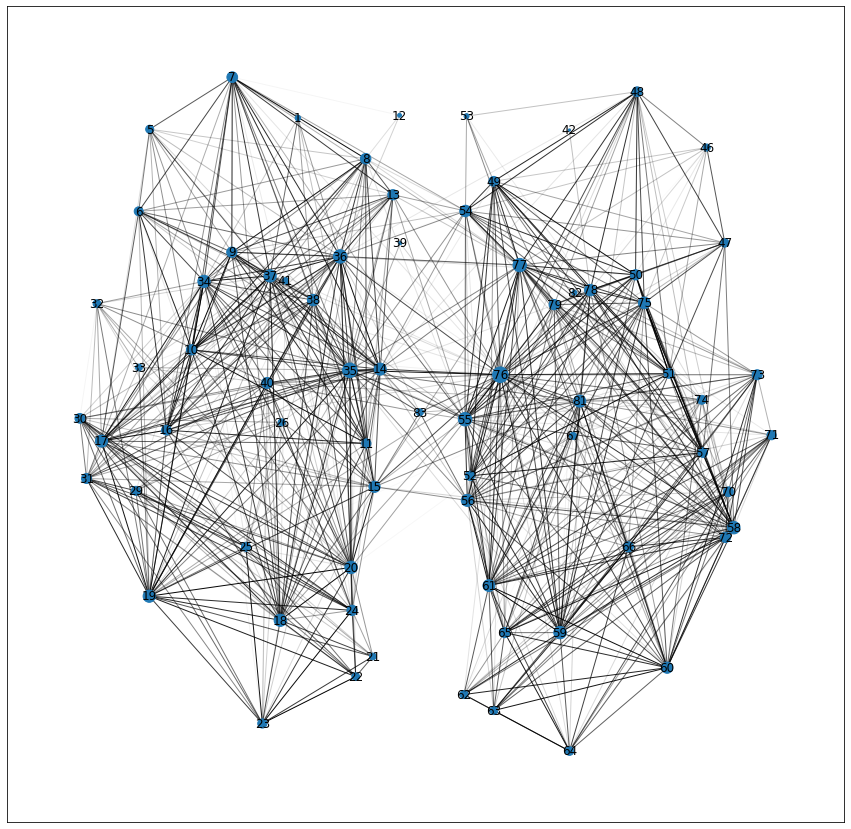

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
node_data = pd.DataFrame(index=g.nodes())
count = 0

#Extract position data from each node
posdict = dict(g.nodes.data("dn_position_x"))
xpos = list()
ypos = list()
for i,v in posdict.items():
    posdict[i] = [g.nodes[i]['dn_position_x'],g.nodes[i]['dn_position_y']]
    xpos.append(g.nodes[i]['dn_position_x'])
    ypos.append(g.nodes[i]['dn_position_y'])
    count+=1
node_data["x"] = xpos
node_data["y"] = ypos

# Vary edge color opacity based on weight for visualization
alphas = list(fibers.values())
colors = [(0,0,0,x) for x in alphas]

#Get degree of each node to adjust node size
node_data["degree"] = node_data.index.map(dict(nx.degree(g)))
nx.draw_networkx(g, posdict,  node_size=node_data["degree"]*5,ax=ax,edge_color=colors,labels=None)



node_data["region"] = list(dict(g.nodes.data("dn_name")).values())
# node_data.reset_index(inplace=True)
# node_data.rename(columns={"index":"node number"})
node_data.head(10)


In our dataset, each node corresponds to a region in the brain. The weights between the edges represent the number of fibers connecting one region of the brain to another. The greater the number the fibers, the stronger the connection. In the network plot visualization, each hemisphere of the brain appears to mostly form connections within itself, with a few nodes in the middle connecting the two, possibly from the activity of the corpus callosum. The dense connections made in each hemisphere explains the two groups we observed the in heatmap. 

Let's also run a leiden partitioning algorithm on our sample dataset to detect further community. Will community detection identity more specialized regions in the brain?


# Leiden Partitioning



0.45514142068747426


(<Figure size 1152x576 with 4 Axes>, <AxesSubplot:>)

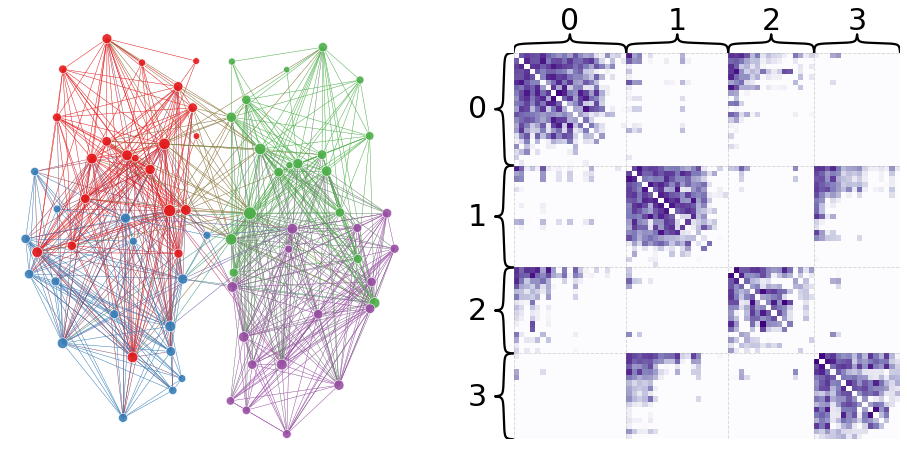

In [5]:
leiden_partition_map = leiden(g, trials = 20)
print(modularity(g, leiden_partition_map))


node_data['leiden_partition'] = node_data.index.map(leiden_partition_map)

def plot_network_partition(adj, node_data, partition_key):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    networkplot(
        adj,
        x="x",
        y="y",
        node_data=node_data.reset_index(),
        node_alpha=0.9,
        edge_alpha=0.7,
        edge_linewidth=0.4,
        node_hue=partition_key,
        node_size="degree",
        edge_hue="source",
        ax=axs[0],
    )
    _ = axs[0].axis("off")

    _ = heatmap(
        adj,
        inner_hier_labels=node_data[partition_key],
        ax=axs[1],
        cbar=False,
        cmap="Purples",
        vmin=0,
        center=None,
        sort_nodes=True,
    )

    return fig, ax

A.shape
plot_network_partition(A, node_data, 'leiden_partition')


For this brain graph in the dataset, the leiden partitioning algorithms reveals that connections within the brain are highly localized. Each node in the brain is more likely to form connections with nearby nodes. This confirms what we know about the brain being made up of specialized and distinct structures. Visually, the shape of the groups in the left and right hemispheres look fairly similar. We can do some more digging to see what regions each group corresponds to.

In [7]:
node_data.sort_values(by=["leiden_partition","degree"],inplace=True,ascending=False, kind="stable")
print("Top 5 regions in group 0: " + ", ".join(list(node_data[node_data["leiden_partition"]==0]["region"].unique())[0:5]))
print("Top 5 regions in group 1: " + ", ".join(list(node_data[node_data["leiden_partition"]==1]["region"].unique())[0:5]))
print("Top 5 regions in group 2: " + ", ".join(list(node_data[node_data["leiden_partition"]==2]["region"].unique())[0:5]))
print("Top 5 regions in group 3: " + ", ".join(list(node_data[node_data["leiden_partition"]==3]["region"].unique())[0:5]))

Top 5 regions in group 0: Right-Thalamus-Proper, Right-Caudate, rh.superiorparietal, rh.insula, Right-Putamen
Top 5 regions in group 1: Left-Thalamus-Proper, lh.posteriorcingulate, Left-Caudate, lh.supramarginal, lh.insula
Top 5 regions in group 2: rh.precuneus, rh.inferiorparietal, rh.isthmuscingulate, Right-Hippocampus, rh.lingual
Top 5 regions in group 3: lh.superiorparietal, lh.isthmuscingulate, Left-Hippocampus, lh.precuneus, lh.inferiorparietal


Observing the brain regions with the greatest number of connections in each group, we can see some correspondence for the left and right hemispheres. For example, we see the right and left thalamus both have the greatest degrees in their respective groups. Upon closer inspection, the left and right have nearly identical regions in the top 5 with a few exceptions.

# Graph classification using standard ML algorithms

Now let's load all 1064 graphs from our dataset and try to classify them with some simple machine learning algorithms. One simple approach would be to get the centrality of each node, and use them as features. Previously, we found that connections in the brain are highly localized. Moreover, considering the importance of information flow in the brain, betweenness centrality appears to be promising measure. Let's extract the betweenness centrality data for each graph and use them as features for machine learning.

## Load all graphs

In [9]:
all_brains = np.empty(shape=(len(all_mats), n,n))
subjects_list = list()
all_centralities = list()
for x in range(len(all_mats)):
    g = nx.read_graphml("braingraph_low/" + all_mats[x])
    #computes centrality
    all_centralities.append(list(nx.betweenness_centrality(g, weight="number_of_fibers").values()))
    A = nx.to_numpy_array(g, weight="number_of_fibers")
    subjects_list.append(int(all_mats[x][0:6]))
    all_brains[x] = A

## Load subject data

In [10]:
subject_labels = pd.read_csv("labels.csv")
subject_labels = subject_labels.loc[subject_labels['Subject'].isin(subjects_list)]
subject_labels

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
5,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,992774,Q2,Q02,M,31-35,True,2,2,4,100.0,...,8.4,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76
1202,993675,S900,Q09,F,26-30,True,2,2,4,100.0,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76
1203,994273,S500,Q06,M,26-30,True,1,1,4,100.0,...,6.0,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76
1204,995174,S1200,Q13,M,22-25,False,1,1,2,0.0,...,3.6,88.61,64.58,3.0,50.1,117.16,117.40,1.80,0.0,1.80


## Gender Classification -- SVM

Let's try a quick test by trying to predict the gender of the subject using the betweenness centrality of each node as input features.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Encode the gender labels
labelencoder = LabelEncoder()
gender_labels = labelencoder.fit_transform(subject_labels["Gender"].tolist())

#Split into training and test set
x_train, x_test, y_train, y_test = train_test_split(all_centralities, gender_labels, test_size=0.2,random_state=109) # 80% training and 20% test

#Hyperparameter tuning
param_grid={'C':[0.1,1,10,100],'kernel':['linear', 'poly', 'rbf']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)
model.fit(x_train,y_train)

#Prediction
y_pred = model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6197183098591549
Precision: 0.6179775280898876
Recall: 0.5392156862745098


Using a SVM for classfication and betweeness centrality of each node as features, the accuracy achieved is quite low. Frankly, it is not much better than guessing at random. Perhaps betweeness centrality doesn't encode enough information unique to each graph. Let's using another approach to extract features from our graphs.

# ML using graph embeddings

Another way to convert our graphs into standard input data is with graph embeddings. Graph embedding transforms the nodes and edges of a graph into vector representations that encodes some relevant information with the associated node. Since all of our graphs contain the same number of nodes representing the same regions, we can use OmnibusEmbed to get vector representations of every node in our dataset and use that as input data.


In [17]:
from graspologic.embed import OmnibusEmbed
from graspologic.utils import multigraph_lcc_intersection
from graspologic.utils import multigraph_lcc_union


#Only use the largest fully connected component common to all graphs in our dataset.
all_brains = multigraph_lcc_intersection(all_brains)
all_brains.shape

(1064, 52, 52)

## Multigraph embedding with Omnibus Embed

In [ ]:
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(all_brains)

After using omnibus embed, we are left with an 8-dimensional vector for each of the 52 connected-nodes common to all of our brain graphs. To use the data as training data, we need to flatten the matrix into a 2d matrix.

In [ ]:
#Resize for SVM data input
resized = omni_embedding.reshape(omni_embedding.shape[:-2] + (-1,))
np.savetxt("input.txt", resized)

## Gender classification with graph embeddings and SVM

In [19]:
x = np.loadtxt("input.txt")
x_train, x_test, y_train, y_test = train_test_split(x, gender_labels, test_size=0.3,random_state=109) # 70% training and 30% test
param_grid={'C':[1,10,100],'kernel':['poly'], 'degree':[3,4,5]}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)
model.fit(x_train,y_train)

y_pred = model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.803125
Precision: 0.7986111111111112
Recall: 0.7718120805369127


Using graph embeddings and a SVM with a polynomial kernel, we get an accuracy of around *80%* for classifying gender, which is a 20% increase from our previous accuracy achieved using betweenness centrality. How does this approach perform with regression? In the dataset, each subject has an MMSE score associated, which is a measure of basic mental skills. Let's try using linear regression to predict MMSE scores.

## Graph regression using graph embeddings and linear regression

In [22]:
from sklearn.linear_model import LinearRegression
str_labels = subject_labels["MMSE_Score"]
regressor = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(x, str_labels, test_size=0.3,random_state=109) # 70% training and 30% test
regressor.fit(x_train, y_train)
print(str_labels.describe(), "\n")
y_pred = regressor.predict(x_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


count    1064.000000
mean       29.008459
std         1.022293
min        23.000000
25%        28.000000
50%        29.000000
75%        30.000000
max        30.000000
Name: MMSE_Score, dtype: float64 

      Actual  Predicted
632       30  28.855957
578       28  30.738770
538       30  28.663574
842       30  28.934082
676       28  28.309082
...      ...        ...
80        28  29.533691
801       28  29.770020
915       29  29.515137
1007      28  30.840332
1116      30  28.262207

[320 rows x 2 columns]
Mean Absolute Error: 1.2976547241210938
Mean Squared Error: 2.7745994668453933
Root Mean Squared Error: 1.665712900485973


Given our dataset, the linear regression to the dataset was fairly poor in predicting subject's MMSE scores. The error metrics are very high relative to the original data's standard deviation.

Some possible explanations for this large error are:<br><br>
<li>Linear regression is insufficent to characterize the high dimensional data from the embedding</li>
<li>The information encoded from omnibus embedding does not characterize the graph well enough to predict MMSE scores</li>
<li>The graph itself does not contain enough nodes or features to predict a rather nuanced measure of mental abilities</li>
<li>Mistake in implementation</li>

# Further Considerations

In this analysis, the dataset used contained only 83 nodes for each brain graph. From the source, graphs of over 1000 nodes for each subject is available. With more computing power, a more comprehensive analysis, such as identification of smaller and distinct communities, as well as more accurate prediction accuracy may be possible. Moreover, different methods of multigraph embeddings or feature extraction, as well as other graph machine learning methods such as CNNs may also be considered for increasing accuracy.